In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [232]:
import yellowbrick as yb 
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.facecolor'] = "white"

from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates
from yellowbrick.features.scatter import ScatterViz


In [3]:
# import pandas as pd
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
# iris = pd.read_csv(url, header=None, names=col_names)
# iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

In [3]:
iris = datasets.load_iris()
feature_df = pd.DataFrame(iris.data[:, :], columns=iris.feature_names)
X = feature_df[['sepal length (cm)', 'sepal width (cm)']]
y = iris.target

In [4]:
X = X.as_matrix()
# y = y.as_matrix()

In [5]:
features = ['sepal length (cm)', 'sepal width (cm)',]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

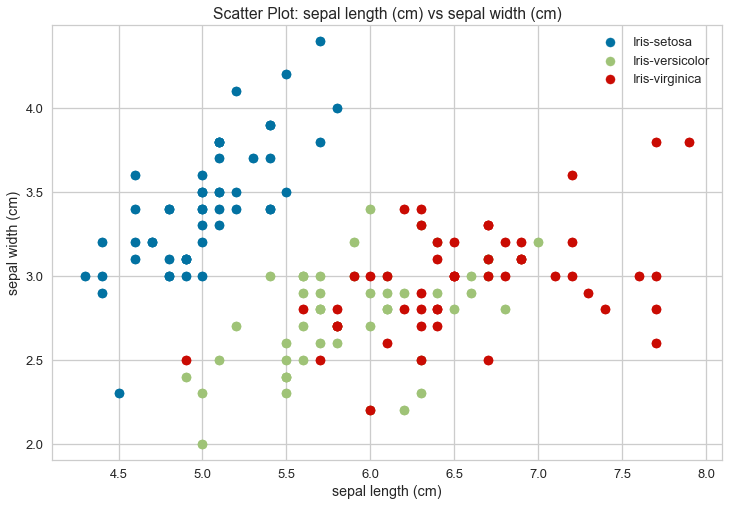

In [6]:
visualizer = ScatterViz(classes=classes, features=features)
visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.poof()         # Draw/show/poof the data

In [8]:
from yellowbrick.classifier import ClassificationScoreVisualizer

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support

from yellowbrick.exceptions import YellowbrickTypeError
from yellowbrick.utils import get_model_name, isestimator, isclassifier
from yellowbrick.base import Visualizer, ScoreVisualizer, MultiModelMixin
from yellowbrick.style.palettes import color_sequence, color_palette, LINE_COLOR

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from yellowbrick.features.base import DataVisualizer
from yellowbrick.utils import is_dataframe
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.style.colors import resolve_colors, get_color_cycle



class ClusterReport(ClassificationScoreVisualizer):
    """
    ScatterVisualizer is a bivariate data visualization algorithm that plots
    using the Cartesian coordinates of each point.
    """

    def __init__(self, model, ax=None, classes=None, **kwargs):
        """
        Check to see if model is an instance of a classifer.
        Should return an error if it isn't.
        """

        super(ClusterReport, self).__init__(model, ax=ax, **kwargs)
        self.cmap = color_sequence(kwargs.pop('cmap', 'YlOrRd'))
        self.classes_ = classes
        self.estimator = model
        self.name = get_model_name(self.estimator)
        
        
    def fit(self, X, y=None, **kwargs):
        """
        Parameters
        ----------

        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        kwargs: keyword arguments passed to Scikit-Learn API.
        """
        super(ClusterReport, self).fit(X, y, **kwargs)
        if self.classes_ is None:
            self.classes_ = self.estimator.classes_
        return self
    
    def score(self, X, y=None, **kwargs):
        """
        Generates the Scikit-Learn classification_report

        Parameters
        ----------

        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        """
        y_pred = self.predict(X)
        keys   = ('precision', 'recall', 'f1')
        self.scores = precision_recall_fscore_support(y, y_pred)
        self.scores = map(lambda s: dict(zip(self.classes_, s)), self.scores[0:3])
        self.scores = dict(zip(keys, self.scores))
        
        
        return self.draw(y, y_pred)
    
     
    def draw(self, X, y, **kwargs):
        """
        Called from the fit method, this method creates a scatter plot that draws
        each instance as a class or target colored point, whose location
        is determined by the feature data set.
        """
        # Get the shape of the data
        nrows, ncols = X.shape

        h = .02
        color_values = get_color_cycle()
        self.colors = OrderedDict(zip(self.classes_, color_values))
        cmap_bold = ListedColormap(self.colors.values())   
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])        

        # Put the result into a color plot
        self.Z = Z.reshape(xx.shape)
        
       
        # Create the axes if they don't exist
        if self.ax is None:
                self.ax = plt.gca(xlim=[-1,1], ylim=[-1,1])      

        labels = [Patch(color=color, label=class_) for class_, color in self.colors.items()]
                
        for i, kls in enumerate(self.classes_):
            plt.figure(i)
            plt.title(kls)
            plt.legend(handles=labels, facecolor="w", shadow=True)
            plt.pcolormesh(xx, yy, self.Z, cmap=cmap_bold)
            
        # Create a data structure to hold the scatter plot representations
        to_plot = {}
        for kls in self.classes_:
            to_plot[kls] = [[], []]

        # Add each row of the data set to to_plot for plotting
        # TODO: make this an independent function for override
        for i, row in enumerate(X):
            row_ = np.repeat(np.expand_dims(row, axis=1), 2, axis=1)
            x_, y_   = row_[0], row_[1]
            kls = self.classes_[y[i]]

            to_plot[kls][0].append(x_)
            to_plot[kls][1].append(y_)

        # Add the scatter plots from the to_plot function
        # TODO: store these plots to add more instances to later
        # TODO: make this a separate function
        for i, kls in enumerate(self.classes_):
            plt.figure(i)
            plt.scatter(to_plot[kls][0], to_plot[kls][1], color=self.colors[kls], label=str(kls), edgecolor='black', **kwargs)
            
        self.ax.axis('equal')

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        # Divide out the two features
#         feature_one, feature_two = self.features_

        # Set the title
#         self.set_title(
#             '{0} Cluster Boundaries'.format(self.name)
#         )
#         # Add the legend
#         self.ax.legend(loc='best')


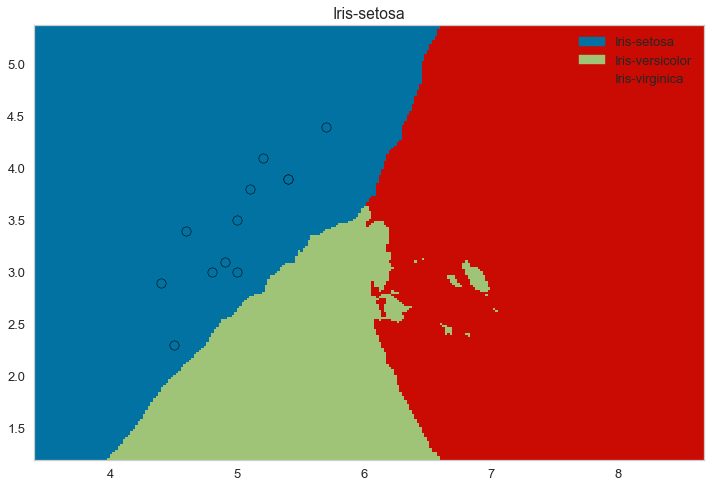

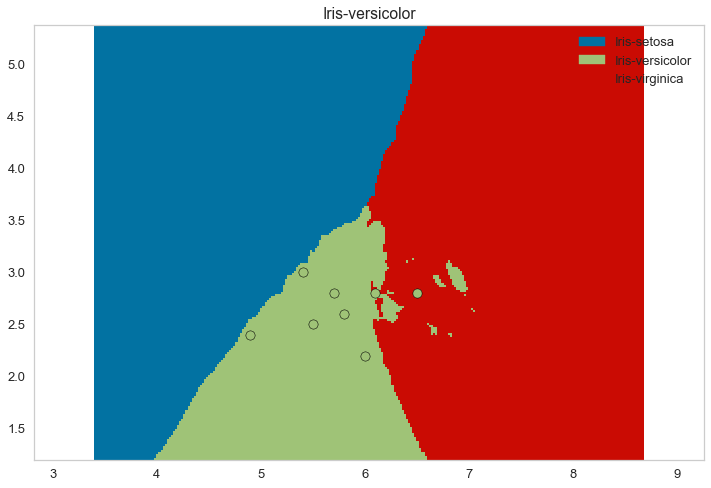

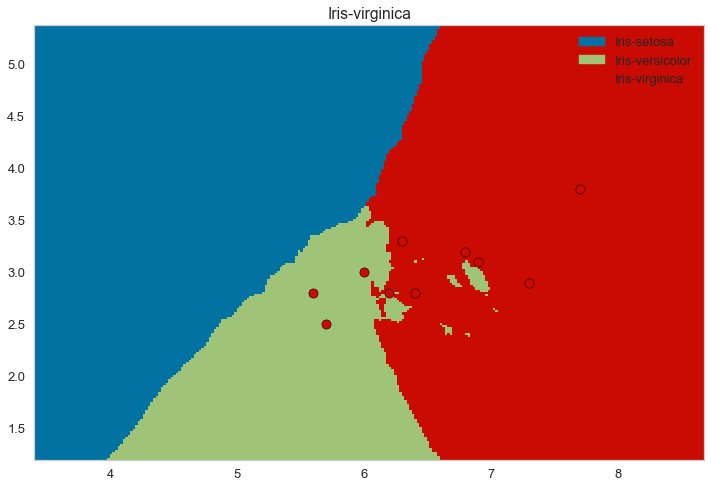

In [235]:
features = ['sepal length (cm)', 'sepal width (cm)',]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn_clf = neighbors.KNeighborsClassifier(15, weights='uniform')

report = ClusterReport(knn_clf, classes=classes)
report.fit(X_train, y_train)
report.draw(X_test, y_test)

# visualizer.fit(X_train, y_train, **kwargs)
# visualizer.score(X_test, y_test)

report.poof()

In [151]:
report

ClusterReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x114744438>,
       classes=None, model=None)